# LEPL1106, Devoir 6 : filtrage d'un signal audio

## Introduction

*20 Cents a fini son beat. Pour l'améliorer, notre artiste favori vous demande de concevoir une fonction qui filtre des signaux audio. Les filtres en question peuvent être passe-bas, passe-haut ou encore passe-bande, selon son envie. On compte sur vous pour l'aider !*

Pour ce devoir, nous allons donc nous intéresser au filtrage de signaux audio. Comme vous le savez, il n'est pas possible de représenter numériquement un signal continu, celui-ci a forcément dû être échantillonné (avec une fréquence d'échantillonnage notée `fech` par la suite). Toutefois, l'objectif de ce devoir est bien de manipuler le concept de filtrage et non celui d'échantillonnage, c'est pourquoi nous vous guiderons tout au long de ce notebook ;-)

In [2]:
# En cas d'erreur avec scipy, essayez de décommenter la ligne suivante pour mettre à jour le package. 
# Nous vous conseillons une version de scipy supérieure à 1.3.0

#!pip install -U scipy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal

import scipy
print(scipy.__version__) # conseil: supérieure à 1.3.0

1.5.2


## Signal audio de 20 Cents

Le signal audio de référence est donné dans le dossider *data*. Commencez par l'écouter en l'ouvrant avec votre lecteur préféré...

Chargeons ensuite ce signal dans Python et définissons une fonction qui nous permet de rapidement afficher le signal en temporel et le module de son spectre, avec les bons axes. Ici, on choisit d'utiliser les fréquences $f$ (en Hz) pour l'axe des abscisses du spectre, et non la pulsation $\omega$ (en rad/s). Pour votre information, un tableau regroupant le passage entre toutes ces quantités est donné dans le **rappel de la séance 8**.

Fréquence d'échantillonnage : 44100 Hz


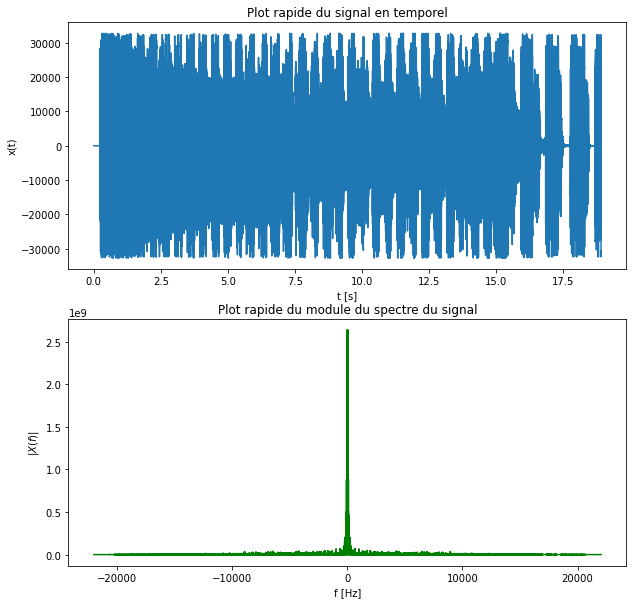

In [4]:
fech, x = read("data/sound.wav") # Music: https://www.purple-planet.com

print("Fréquence d'échantillonnage :", fech, "Hz")

def simple_plot(x,fech):
    """
    Permet de rapidement représenter le signal x en temporel, ainsi que le module de son spectre (en fréquentiel), avec les bons axes
    x : signal temporel, échantillonné à la fréquence fech
    fech : fréquence d'échantillonnage, en Hz
    """
    t = 1/fech*np.arange(0,len(x))
    
    # Calcul du spectre via la FFT et calcul des abscisses correspondantes, exprimées en fréquence f [Hz]
    X = np.fft.fftshift(np.fft.fft(x))
    f = fech/len(X)*np.arange(-np.ceil((len(X)-1)/2),np.floor((len(X)-1)/2)+1)
    
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(t,x)
    plt.title("Plot rapide du signal en temporel")
    plt.xlabel("t [s]")
    plt.ylabel("x(t)")
  
    plt.subplot(2,1,2)
    plt.plot(f,np.abs(X), color="g")
    plt.title("Plot rapide du module du spectre du signal")
    plt.xlabel("f [Hz]")
    plt.ylabel("$|X(f)|$")
    plt.show()

simple_plot(x,fech)

## Conception du filtre

Pour concevoir votre filtre, utilisez les fonctions `scipy.signal.firwin`, `scipy.signal.filtfilt` et  `scipy.signal.freqz` du package [SciPy](https://docs.scipy.org/) de Python. Vous pouvez facilement accéder au docstring de ces fonctions :


In [5]:
help(signal.firwin) #signal.firwin #signal.filtfilt #signal.freqz

Help on function firwin in module scipy.signal.fir_filter_design:

firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=None)
    FIR filter design using the window method.
    
    This function computes the coefficients of a finite impulse response
    filter. The filter will have linear phase; it will be Type I if
    `numtaps` is odd and Type II if `numtaps` is even.
    
    Type II filters always have zero response at the Nyquist frequency, so a
    ValueError exception is raised if firwin is called with `numtaps` even and
    having a passband whose right end is at the Nyquist frequency.
    
    Parameters
    ----------
    numtaps : int
        Length of the filter (number of coefficients, i.e. the filter
        order + 1).  `numtaps` must be odd if a passband includes the
        Nyquist frequency.
    cutoff : float or 1-D array_like
        Cutoff frequency of filter (expressed in the same units as `fs`)
        OR an array of cut

La fonction `scipy.signal.firwin` construit et renvoie donc les coefficients d'un filtre FIR, c'est-à-dire les coefficients $b_0,b_1,\dots,b_{M-1}$ tels que

$$h[n] = b_0\delta[n] + b_1\delta[n-1] + \dots + b_{M-1}\delta[n-(M-1)]$$

avec `M` le nombre de coefficients du filtre. Remarquez que la réponse impulsionnelle de ce filtre est exprimée ici en temps discret, vu que nous manipulons un signal continu qui a été échantillonné pour donner un signal discret et qui est filtré en temps discret. Toutefois, pour que `scipy.signal.firwin` travaille "comme si on était en temps continu", n'oubliez pas de lui spécifier la période d'échantillonnage (argument `fs`). Dans ce cas, l'argument `cutoff` représente la fréquence de coupure de votre filtre par rapport à `fs`. En outre, l'information du type de filtre à réaliser (passe-bas, passe-haut ou passe-bande) est à donner à l'argument `pass_zero`. Pour le reste, nous utiliserons les valeurs des paramètres par défaut (par exemple, Python utilise une fenêtre de type `Hamming` dans ce cas, qui est un peu plus élaborée qu'une fenêtre rectangulaire).

Ensuite, sur base des coefficients renvoyés par `scipy.signal.firwin`, la fonction `scipy.signal.filtfilt` est appelée afin de filtrer le signal audio `x`. Vous pouvez utiliser les valeurs par défaut pour les différents paramètres, attention toutefois à bien spécifier ses arguments `b`, `a` et `x`. Le filtre que nous considérons ici n'a pas de coefficients au dénominateur (vu autrement, il possède un unique coefficient au dénominateur valant 1). Le signal filtré récupéré en sortie est noté `xf`.

Enfin, la dernière fonction qui vous sera utile est `scipy.signal.freqz`. Celle-ci permet de calculer la réponse fréquentielle d'un filtre sur base de ses coefficients (ceux renvoyés par `scipy.signal.firwin`). En effet, en plus de construire et appliquer le filtre FIR sur `x`, nous vous demandons aussi de calculer sa réponse fréquentielle sur $\left[\frac{-f_{ech}}{2},\frac{f_{ech}}{2}\right[$ (domaine des fréquences $f$ en Hz). Attention que `scipy.signal.freqz` renvoie la réponse fréquentielle sur le domaine $[0,f_{ech}[$ si l'argument `fs` est spécifié (avec l'option `whole=True` que nous vous demandons d'utiliser, les autres paramètres étant ceux par défaut), il vous faudra donc appliquer un `np.fft.fftshift` et modifier les abscisses `f` obtenues.

> Oui et je fais quoi moi de toutes ces informations maintenant ?
>
> -- étudiant anonyme

Eh bien à vous de compléter la fonction `audioFiltering(x,typeF,M,cutoff,fech)` qui conçoit et applique le filtre FIR sur le signal `x` en entrée. L'argument `x` est un vecteur (``numpy array``) de longueur $N$ et dont les entrées sont des valeurs réelles. Le support du signal `x` est donc $\{0,\dots,N-1\}$.
L'argument `typeF` est un string indiquant le type de filtre à concevoir. Il prend ses valeurs dans {'lowpass','highpass','bandpass'}.
L'argument `M` est un entier impair strictement positif correspondant à la longueur du filtre à concevoir (càd l'ordre du filtre + 1).
Finalement, l'argument `cutoff` est un scalaire ou un vecteur (`numpy array`) de longueur $2$. Il s'agit de la fréquence de coupure du filtre. Si le filtre est passe-bas ou passe-haut, cette fréquence est un scalaire. Si le filtre est passe-bande, il s'agit d'un vecteur.

La fonction doit renvoyer trois vecteurs (`numpy array`) : `xf`, `f` et `H` décrits ci-dessous (attention à bien retourner `(xf,f,H)`).

L'output `xf` est un vecteur (`numpy array`) de longueur $N$ contenant les valeurs du signal filtré. L'output `f` est un vecteur (`numpy array`) contenant les fréquences en Hz où est évaluée la réponse fréquentielle de votre filtre (pour la fréquence d'échantillonnage choisie). Finalement, l'output ``H`` est un vecteur (`numpy array`) de la même longueur que `f` contenant les valeurs possiblement complexes de la réponse fréquentielle, sur une période allant de $-\frac{f_{ech}}{2}$ à $\frac{f_{ech}}{2}$.

In [6]:

def audioFiltering(x,typeF,M,cutoff,fech):
    """
    [extended_summary]

    Args:
        x ([type]): [description]
        typeF ([type]): [description]
        M ([type]): [description]
        cutoff ([type]): [description]
        fech ([type]): [description]

    Returns:
        [type]: [description]
    """
    b = scipy.signal.firwin(M,cutoff,pass_zero=typeF,fs=fech)
    xf = scipy.signal.filtfilt(b,1,x)
    oldf,oldH = scipy.signal.freqz(b,1,whole=True,fs=fech)
    f = np.linspace(-fech/2,fech/2,num=len(oldH))
    H = np.fft.fftshift(oldH)

    return (xf,f,H)

Finalement, complétez également la fonction `plotFilter(f,H,name)` qui crée et sauvegarde une figure affichant le **module de la réponse fréquentielle** du filtre, **sur l'axe des fréquences $f$** en Hz.

Pour ce faire, utilisez la librairie [Matplotlib](https://matplotlib.org/index.html>). La fonction sauve également la figure au format png avec le nom `name` (la sauvegarde est déjà implémentée pour vous, ne supprimez pas ces lignes !). Faites attention à respecter la convention d'affichage d'un spectre continu, à annoter convenablement vos axes (labels, unités...), et à donner un titre.

In [7]:
# LE CONTENU DE CETTE CELLULE EST A SOUMETTRE SUR INGINIOUS


def plotFilter(f,H,name,bool_Ingi = True):
    """
    Fonction de plot de la réponse fréquentielle d'un filtre (passe bas, haut, bande)

    Args:
        f (numpay array): Axe frequentielle allant de -fech/2 a fech/2
        H (numpay array): Module de la réponse fréquentielle calculé par la fonction
                          audioFiltering
        name (string): Nom du fichier de sortie si bool_ingi est égal a True
        bool_Ingi (bool, optional): Si True enregistre le plot dans un 
                                    ficher png au nom de name. Defaults to True.
    """
    
    plt.figure(figsize=(10,5))
    
    plt.title("Reponse fréquentielle")
    plt.plot(f,abs(H), label="Réponse du filtre")
    plt.xlabel("Fréquence f [Hz]")
    plt.ylabel("Module de la réponse fréquentielle")
    plt.legend()

    # Pour permettre l'affichage dans le notebook et la sauvegarde sur Inginious (ne pas modifier !)
    if bool_Ingi:
        plt.savefig(name + '.png', bbox_inches='tight')
    else:
        plt.show()
    
    return

## Test sur un signal simple

Avant d'appliquer la fonction `audioFiltering(x,typeF,M,cutoff,fech)` au signal `x` de *20 Cents*, vérifions que celle-ci réalise les opérations attendues. Pour cela, considérons un signal `y` donné par la somme entre une constante et un cosinus à la fréquence de 1000 Hz : 

$$ y(t) = 2+\cos(2\pi 1000 t)$$

et vérifions qu'après filtrage passe-bas, seule la composante DC du signal est récupérée. Au contraire, après filtrage passe-haut, seules les oscillations du cosinus doivent être récupérées.

Nous choississons une fréquence d'échantillonnage de 20000 Hz (ce qui est largement suffisant pour respecter le théorème de Shannon).

**Signal y**


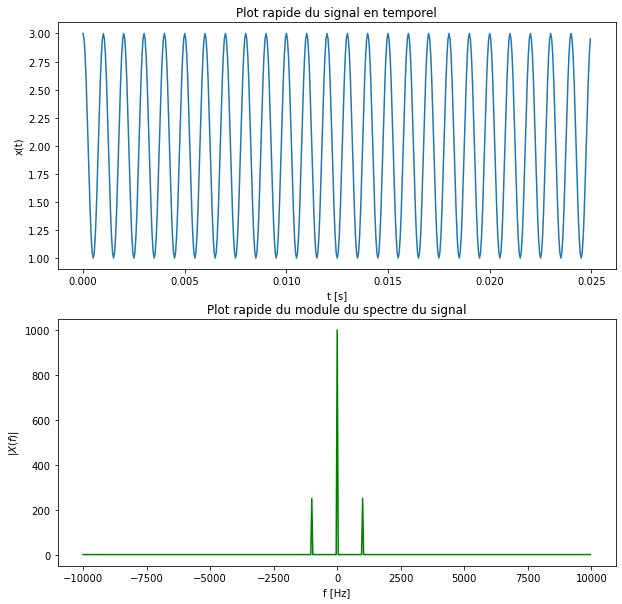

**Filtrage passe-bas**
Réponse fréquentielle du filtre utilisé :


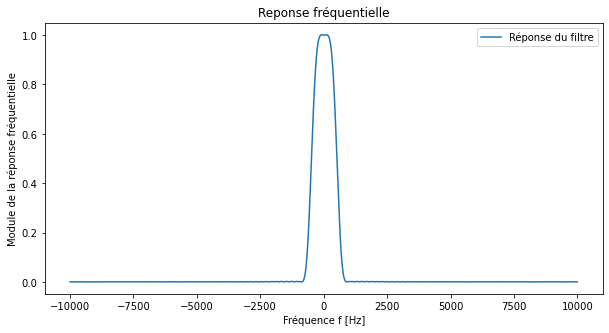

Signal de sortie :


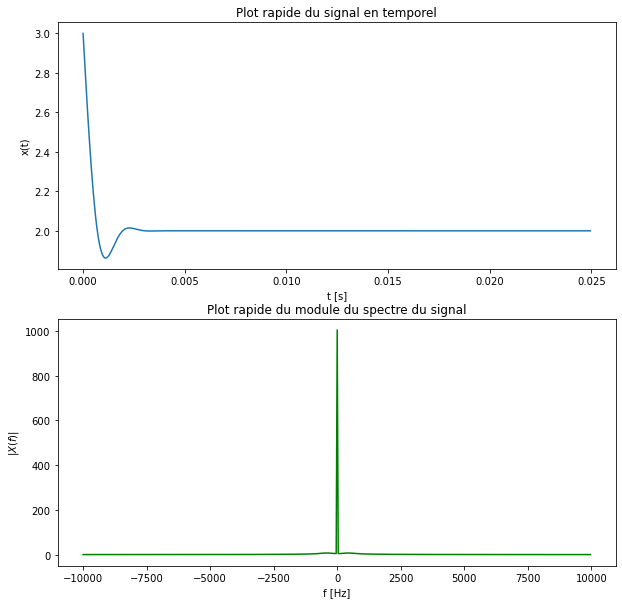

**Filtrage passe-haut**
Réponse fréquentielle du filtre utilisé :


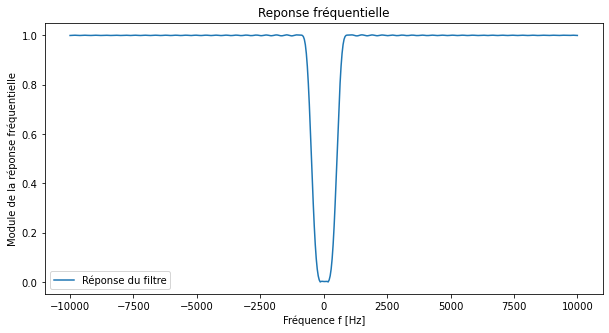

Signal de sortie :


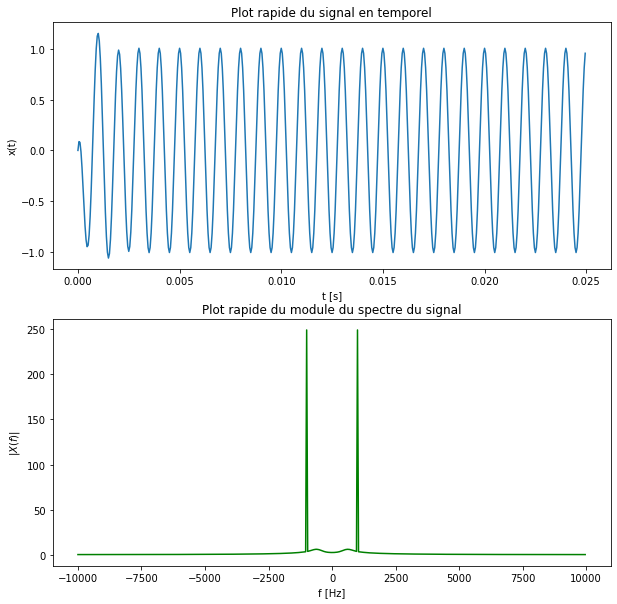

In [8]:
## CELLULE DE TEST

fech = 20000 # fréquence d'échantillonnage

t = np.arange(0,0.5,1/fech) # vecteur temps de 0 à 500 ms
y = 2 + np.cos(2*np.pi*1000*t)

print("**Signal y**")
simple_plot(y[0:int(len(y)/20)],fech) # troncature du signal, pour la lisibilité du plot



print("**Filtrage passe-bas**")
(y_low,f,H) = audioFiltering(y,'lowpass',101,500,fech) # fréquence de coupure passe-bas à 500 Hz
print("Réponse fréquentielle du filtre utilisé :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(y_low[0:int(len(y_low)/20)],fech)



print("**Filtrage passe-haut**")
(y_high,f,H) = audioFiltering(y,'highpass',101,500,fech) # fréquence de coupure passe-haut à 500 Hz
print("Réponse fréquentielle du filtre utilisé :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(y_high[0:int(len(y_high)/20)],fech)

Si votre code fonctionne correctement, vous devriez obtenir un signal $y_{low}(t)$ correspondant uniquement à la composante DC de $y(t)$, et qui vaut donc 2 pour tous les $t$. Notez qu'il est normal d'observer un léger délai au début avant d'obtenir effectivement $2$ pour tous les $t$, à cause de la réponse impulsionnelle finie du filtre. Par ailleurs, dans le cas du filtrage passe-haut, vous devez obtenir un signal $y_{high}(t)=\cos(2\pi 1000 t)$, après un petit délai. Observez les spectres obtenus. Correspondent-ils à vos attentes ?

## Application du filtre au signal de *20 Cents*
Si votre filtre a l'air de se comporter comme attendu, vous pouvez maintenant l'appliquer au signal audio de *20 Cents*. Commençons par recharger en mémoire ce signal (au cas où vous auriez redéfini une variable `x` dans votre implémentation) et le représenter, afin de plus facilement observer les effets du filtrage.

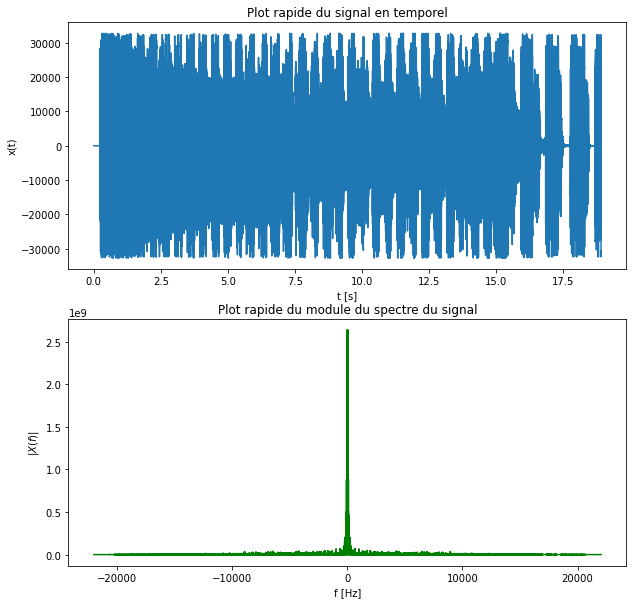

In [9]:
fech, x = read("data/sound.wav") # On recharge en mémoire le signal de 20 Cents (au cas où il aurait été modifié...)

simple_plot(x,fech)

Appliquons et affichons maintenant les différents filtres :

Réponse fréquentielle du filtre passe-bas :


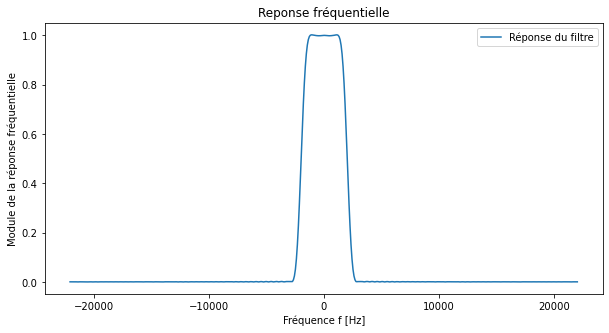

Signal de sortie :


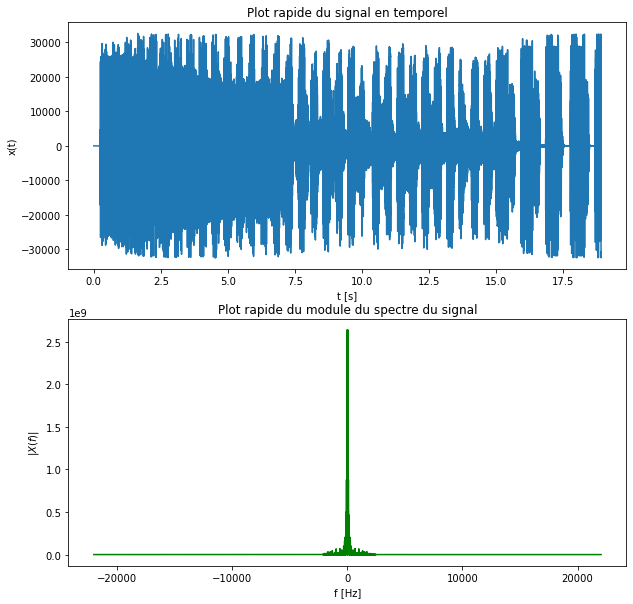

In [10]:
## CELLULE DE TEST - filtrage passe-bas

# On applique un filtre passe-bas pour tuer les fréquences supérieures à 2 kHz
(x_low,f,H) = audioFiltering(x,'lowpass',101,2000,fech)

print("Réponse fréquentielle du filtre passe-bas :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(x_low,fech)

# Enregistrement du son pour vous permettre d'écouter les effets du filtrage passe-bas
write("passe_bas.wav",fech,np.asarray(x_low, dtype=np.int16)) 

Réponse fréquentielle du filtre passe-haut :


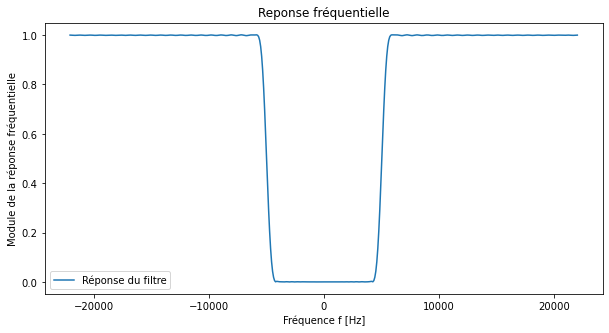

Signal de sortie :


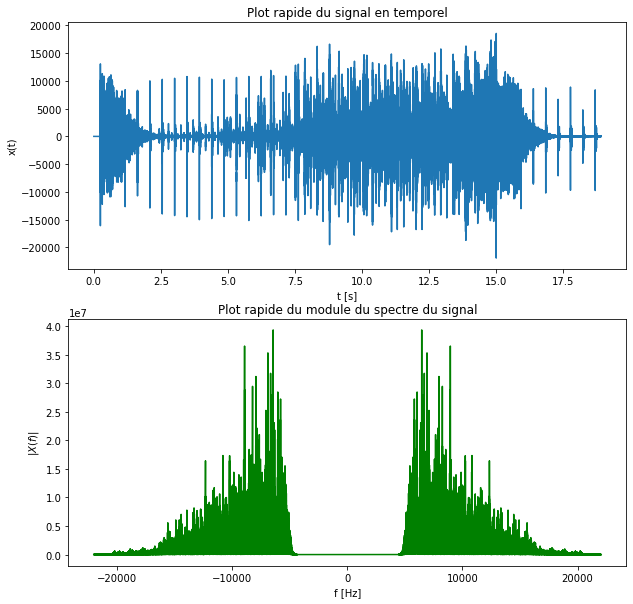

In [11]:
## CELLULE DE TEST - filtrage passe-haut

# On applique un filtre passe-haut pour tuer les fréquences inférieures à 5 kHz
(x_high,f,H) = audioFiltering(x,'highpass',101,5000,fech)

print("Réponse fréquentielle du filtre passe-haut :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(x_high,fech)

# Enregistrement du son pour vous permettre d'écouter les effets du filtrage passe-haut
write("passe_haut.wav",fech,np.asarray(x_high, dtype=np.int16))

Réponse fréquentielle du filtre passe-bande :


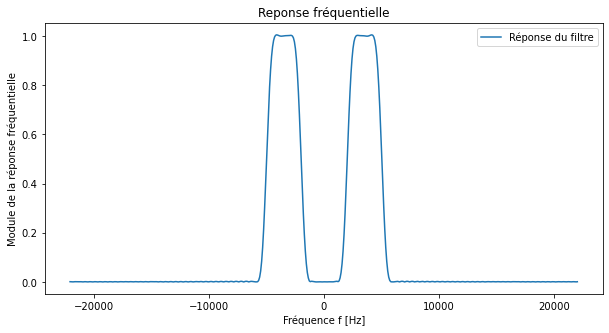

Signal de sortie :


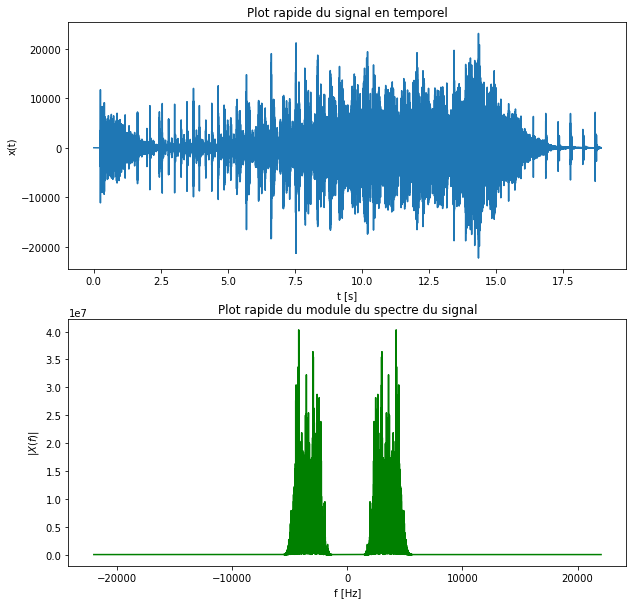

In [12]:
## CELLULE DE TEST - filtrage passe-bande

# On applique un filtre passe-bande pour récupérer seulement les fréquences entre 2000 et 5000 Hz
(x_high,f,H) = audioFiltering(x,'bandpass',101,[2000,5000],fech)

print("Réponse fréquentielle du filtre passe-bande :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(x_high,fech)

# Enregistrement du son pour vous permettre d'écouter les effets du filtrage passe-haut
write("passe_bande.wav",fech,np.asarray(x_high, dtype=np.int16))

Si tout s'est déroulé correctement, vous pouvez maintenant écouter le son de *20 Cents* filtré. En outre, observez les spectres affichés ci-dessus. Correspondent-ils à vos attentes pour un filtrage passe-bas, passe-haut ou passe-bande, avec les fréquences de coupure spécifiées ?